# Vanilla Markowitz Model

Import the libraries

In [165]:
import numpy as np
import pandas as pd 

# For portfolio optimization
from scipy.optimize import minimize, LinearConstraint, Bounds
from matplotlib import pyplot as plt
import seaborn as sns

Reading Finance Data

In [166]:
# import the data from  local file
stock_data=pd.read_excel('Daily_Returns.xlsx')

# Convert the 'date' column to datetime format 
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set the 'date' column as the index
stock_data.set_index('Date', inplace=True)

Breaking training and testing

In [168]:
# Creating the training dataset from the beginning of 2000 to the end of 2021
train = stock_data['2000':'2021']

# Creating the testing dataset from the beginning of 2021 to the end of 2023
test = stock_data['2022':'2023']

Getting the initial data ready

In [169]:
#Renaming the training data
df = train

In [170]:
# Calculate annualized average return for each stock. 
r = np.mean(df,axis=0)*252

# Create a covariance matrix
covar = df.cov()

In [171]:
#rate of return for the whole portfolio
def ret(r,w):
    return r.dot(w)
# Risk level - or volatility
def vol(w,covar):
    return np.sqrt(np.dot(w,np.dot(w,covar)))*np.sqrt(252)

#Find the total number of assets we are considering
num_assets = df.shape[1]

Creating the portfolio with the maximum return

In [176]:
# Function to minimize - negative portfolio returns (to maximize returns)
def negative_portfolio_returns(weights):
    return -np.sum(r * weights)


# Define a function to calculate portfolio volatility (risk)
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights, np.dot(weights, covar)))*np.sqrt(252)

In [177]:
#Sum of weights should be 1
weight_sum_constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#Weights should be between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))

#Initiate the weights
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=[weight_sum_constraint])

#Find the weights
w_max = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_max)
print("Return:", ret(r, w_max), "Risk:", portfolio_volatility(w_max))

Optimal Weights:
[4.30116012e-14 3.33682734e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.03567282e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.99540858e-15 1.38413586e-14
 1.37554898e-13 3.85802501e-15 2.01592215e-14 1.07702909e-13
 8.41340886e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.16005902e-14 0.00000000e+00 1.04291575e-14
 3.68576697e-14 0.00000000e+00 0.00000000e+00 7.26719032e-14
 2.14628662e-14 0.00000000e+00 0.00000000e+00 1.12106505e-14
 3.49798315e-14 0.00000000e+00 2.02546313e-14 0.00000000e+00
 1.71737624e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.88998123e-14 3.76400300e-14 0.00000000e+00 1.53436291e-15
 1.97992664e-14 0.00000000e+00 3.98292510e-15 0.00000000e+00
 0.00000000e+00 2.73453135e-14 0.00000000e+00 6.17301349e-15
 8.70050559e-15 0.00000000e+00 0.00000000e+00 2.57441637e-14
 2.20466007e-14 6.64832772e-15 9.28345942e-14 0.00000000e+00
 1.2732

Creating the portfolio with the minimum risk

In [179]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
constraint_matrix = np.ones((1, num_assets))
linear_constraint = LinearConstraint(constraint_matrix, [1], [1])

# Find a portfolio with the minimum risk.
# Create x0, the first guess at the values of each stock's weight.
initial_weights = np.ones(num_assets) / num_assets

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(portfolio_volatility, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds)

# These are the weights of the stocks in the portfolio with the lowest level of risk possible.
w_min = res.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_min)
print("Return:",ret(r, w_min), "Risk:", portfolio_volatility(w_min))

Optimal Weights:
[1.51121951e-06 2.59455179e-06 1.01447776e-01 2.34674712e-06
 1.18263449e-06 1.37808628e-06 1.71295070e-06 1.54641721e-06
 1.08826324e-06 9.95745357e-07 6.55448570e-07 1.10969633e-06
 2.22554105e-06 3.65261165e-06 3.50717994e-06 8.98568373e-07
 8.31179840e-07 7.42602164e-07 1.56840412e-06 8.30591321e-06
 8.52940673e-07 1.28506330e-06 2.50082969e-06 3.47546887e-06
 4.40795768e-06 2.40559604e-02 1.39734299e-06 5.57682493e-06
 8.49588370e-07 1.46879076e-06 1.43962393e-06 2.54040232e-06
 1.95405000e-06 7.96809374e-06 1.90372395e-06 2.69277643e-06
 1.32249586e-06 8.23183472e-07 4.96218983e-06 8.66770640e-07
 7.34340110e-07 7.55383769e-06 1.06036435e-06 4.91860553e-03
 2.93925623e-06 2.05449278e-06 7.77809944e-06 9.73834032e-07
 1.88684800e-06 1.09649159e-06 9.71342743e-07 8.93434537e-06
 6.09989416e-03 3.12491686e-05 1.34961042e-06 1.35010116e-06
 1.39543746e-06 6.25791440e-07 2.67797575e-02 1.70616107e-06
 1.30239484e-06 1.50836430e-06 9.40776548e-02 7.27942476e-07
 5.5525

Finding the efficient frontier

In [181]:
#Let us now find the risk free rate
risk_free_values = [
    1.45 / 100,
    3.96 / 100,
    2.95 / 100,
    1.45 / 100,
    0.89 / 100,
    2.14 / 100,
    2.91 / 100,
    2.33 / 100,
    1.84 / 100,
    2.14 / 100,
    2.54 / 100,
    2.35 / 100,
    1.80 / 100,
    2.78 / 100,
    3.22 / 100,
    3.26 / 100,
    3.66 / 100,
    4.63 / 100,
    4.80 / 100,
    4.29 / 100,
    4.27 / 100,
    4.01 / 100,
    4.61 / 100,
    5.02 / 100,
    6.03 / 100
]

# Python program to get average of a list 
def Average(lst): 
    return sum(lst) / len(lst) 


# Get the average risk free rate 
rfr = Average(risk_free_values)
print(rfr)

0.03173200000000001


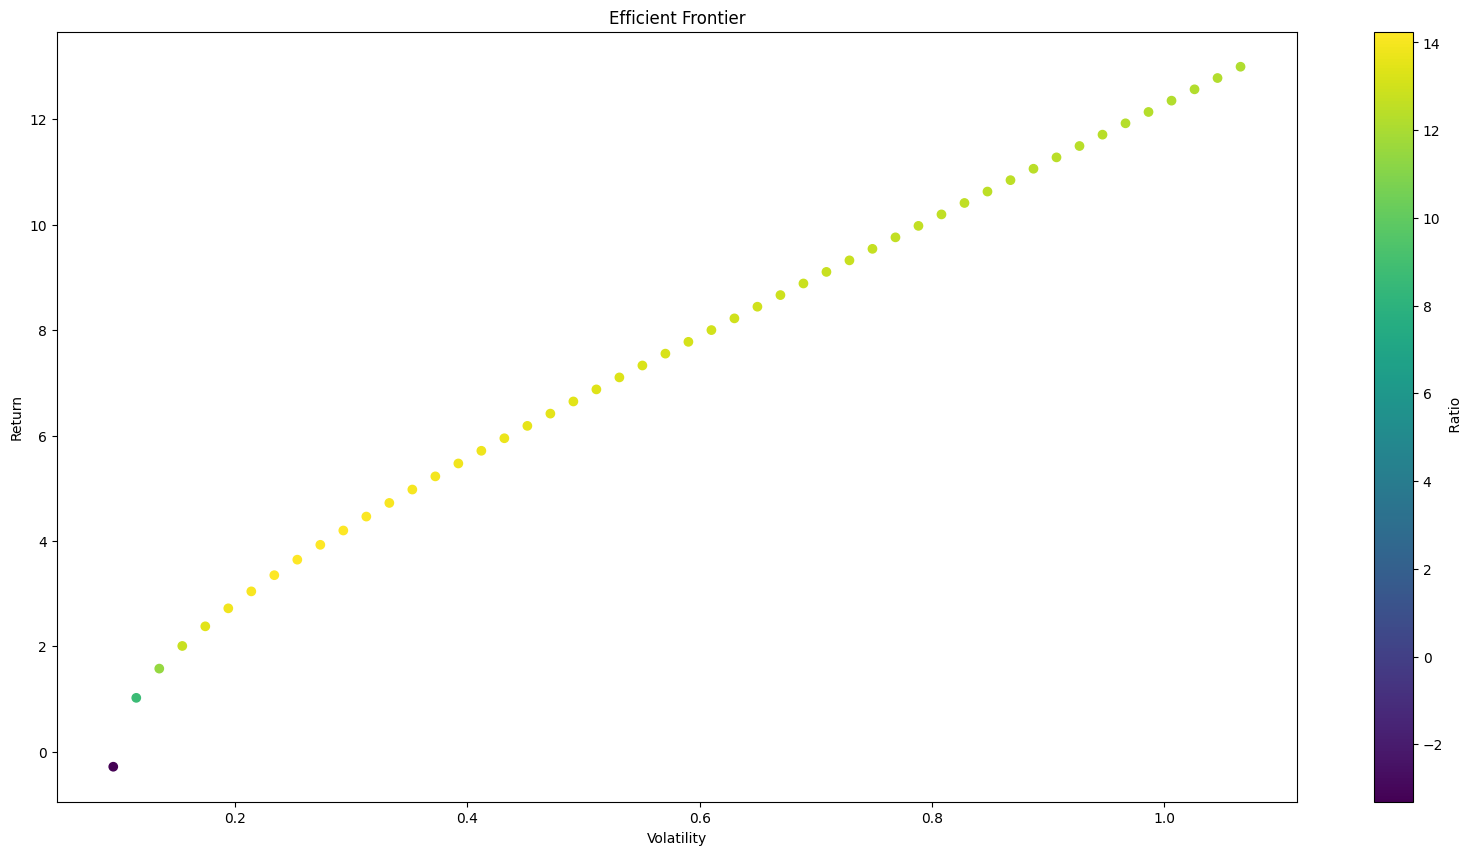

In [182]:
# Define the new objective function to maximize return (minimize negative return)
def negative_portfolio_return(weights):
    return -ret(r, weights)  # We use the previously defined ret function

# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50
all_weights = np.zeros((num_ports, num_assets))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = portfolio_volatility(w_min)
vol_max = portfolio_volatility(w_max)
gap = (vol_max - vol_min) / (num_ports)

# Loop through to generate portfolios with increasing risk and maximizing return
for i in range(num_ports):
    target_vol = vol_min + i * gap

    # Constraint to ensure sum of weights is 1 and to fix the portfolio volatility
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
                    {'type': 'ineq', 'fun': lambda weights: target_vol - portfolio_volatility(weights)}]  # Volatility not more than target
    bounds = Bounds(0, 1)

    #Find the optimum results
    result = minimize(negative_portfolio_return,initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    # Storing the results
    all_weights[i, :] = result.x
    ret_arr[i] = ret(r, result.x)
    vol_arr[i] = target_vol
 

# Calculate Sharpe ratios for each portfolio
sharpe_arr = (ret_arr-rfr)/ vol_arr

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label=' Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Finding the portfolio for a risk value of 15%

In [183]:
#Sum of weights must be 1 and the risk must be less than 15%
constraint = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'ineq', 'fun': lambda weights: 0.1500 - portfolio_volatility(weights)}]
                         

#Weights are between 0 and 1
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = np.ones(num_assets) / num_assets

# Perform MVO optimization
result = minimize(negative_portfolio_returns, initial_weights, method='SLSQP', bounds=bounds, constraints=constraint)

#Find the weights
w_allocation = result.x

# Print the optimal weights and corresponding return and risk
print("Optimal Weights:")
print(w_allocation)
print("Return:", ret(r, w_allocation), "Risk:", portfolio_volatility(w_allocation))

Optimal Weights:
[0.00000000e+00 0.00000000e+00 6.26606474e-14 1.01111993e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.79169243e-15 6.37444748e-15 6.00214700e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.65899564e-13
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.94729344e-02 0.00000000e+00 3.67885053e-15
 7.12276298e-15 0.00000000e+00 0.00000000e+00 7.56711559e-14
 0.00000000e+00 7.01319386e-15 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.40659738e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.07687521e-03
 0.00000000e+00 0.00000000e+00 4.61367819e-15 0.00000000e+00
 1.56644797e-15 3.27295698e-15 0.00000000e+00 7.22769151e-16
 1.47453962e-14 1.82410326e-14 0.00000000e+00 0.00000000e+00
 8.54528481e-16 0.00000000e+00 5.91860639e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.28776281e-14 0.00000000e+00
 1.3289

Creating the asset allocation chart

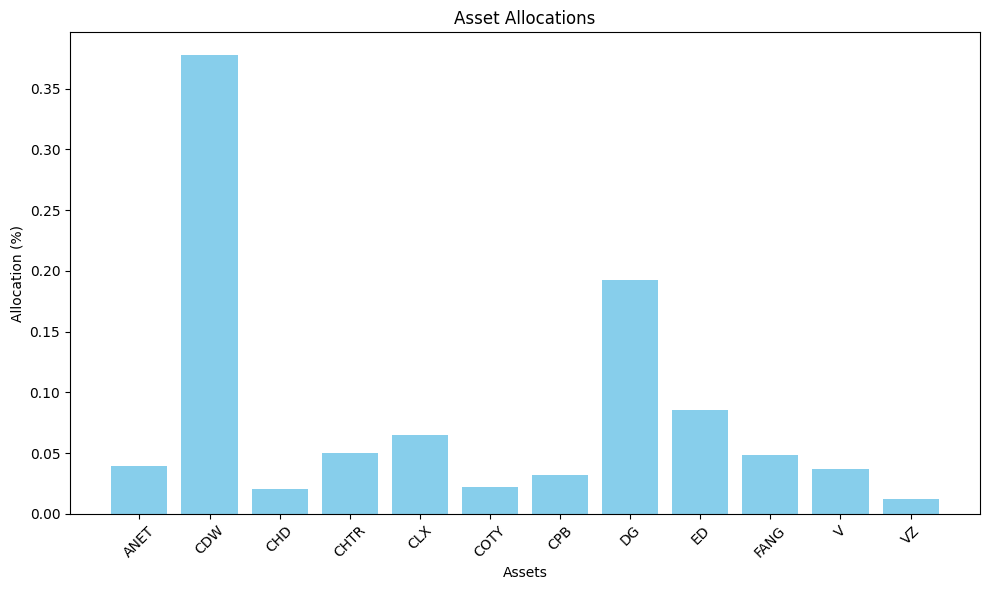

In [184]:
column_names = df.columns.tolist()

# Filter the weights and corresponding names for weights > 0.01
filtered_weights = [w for w in w_allocation if w > 0.01]
filtered_names = [column_names[i] for i, w in enumerate(w_allocation) if w > 0.01]
# Plotting the bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(filtered_names, filtered_weights, color='skyblue') 
plt.xlabel('Assets')  # Adding x-label
plt.ylabel('Allocation (%)')  # Adding y-label
plt.title('Asset Allocations')  # Adding title
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability if names are long
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Creating the correlation heatmap

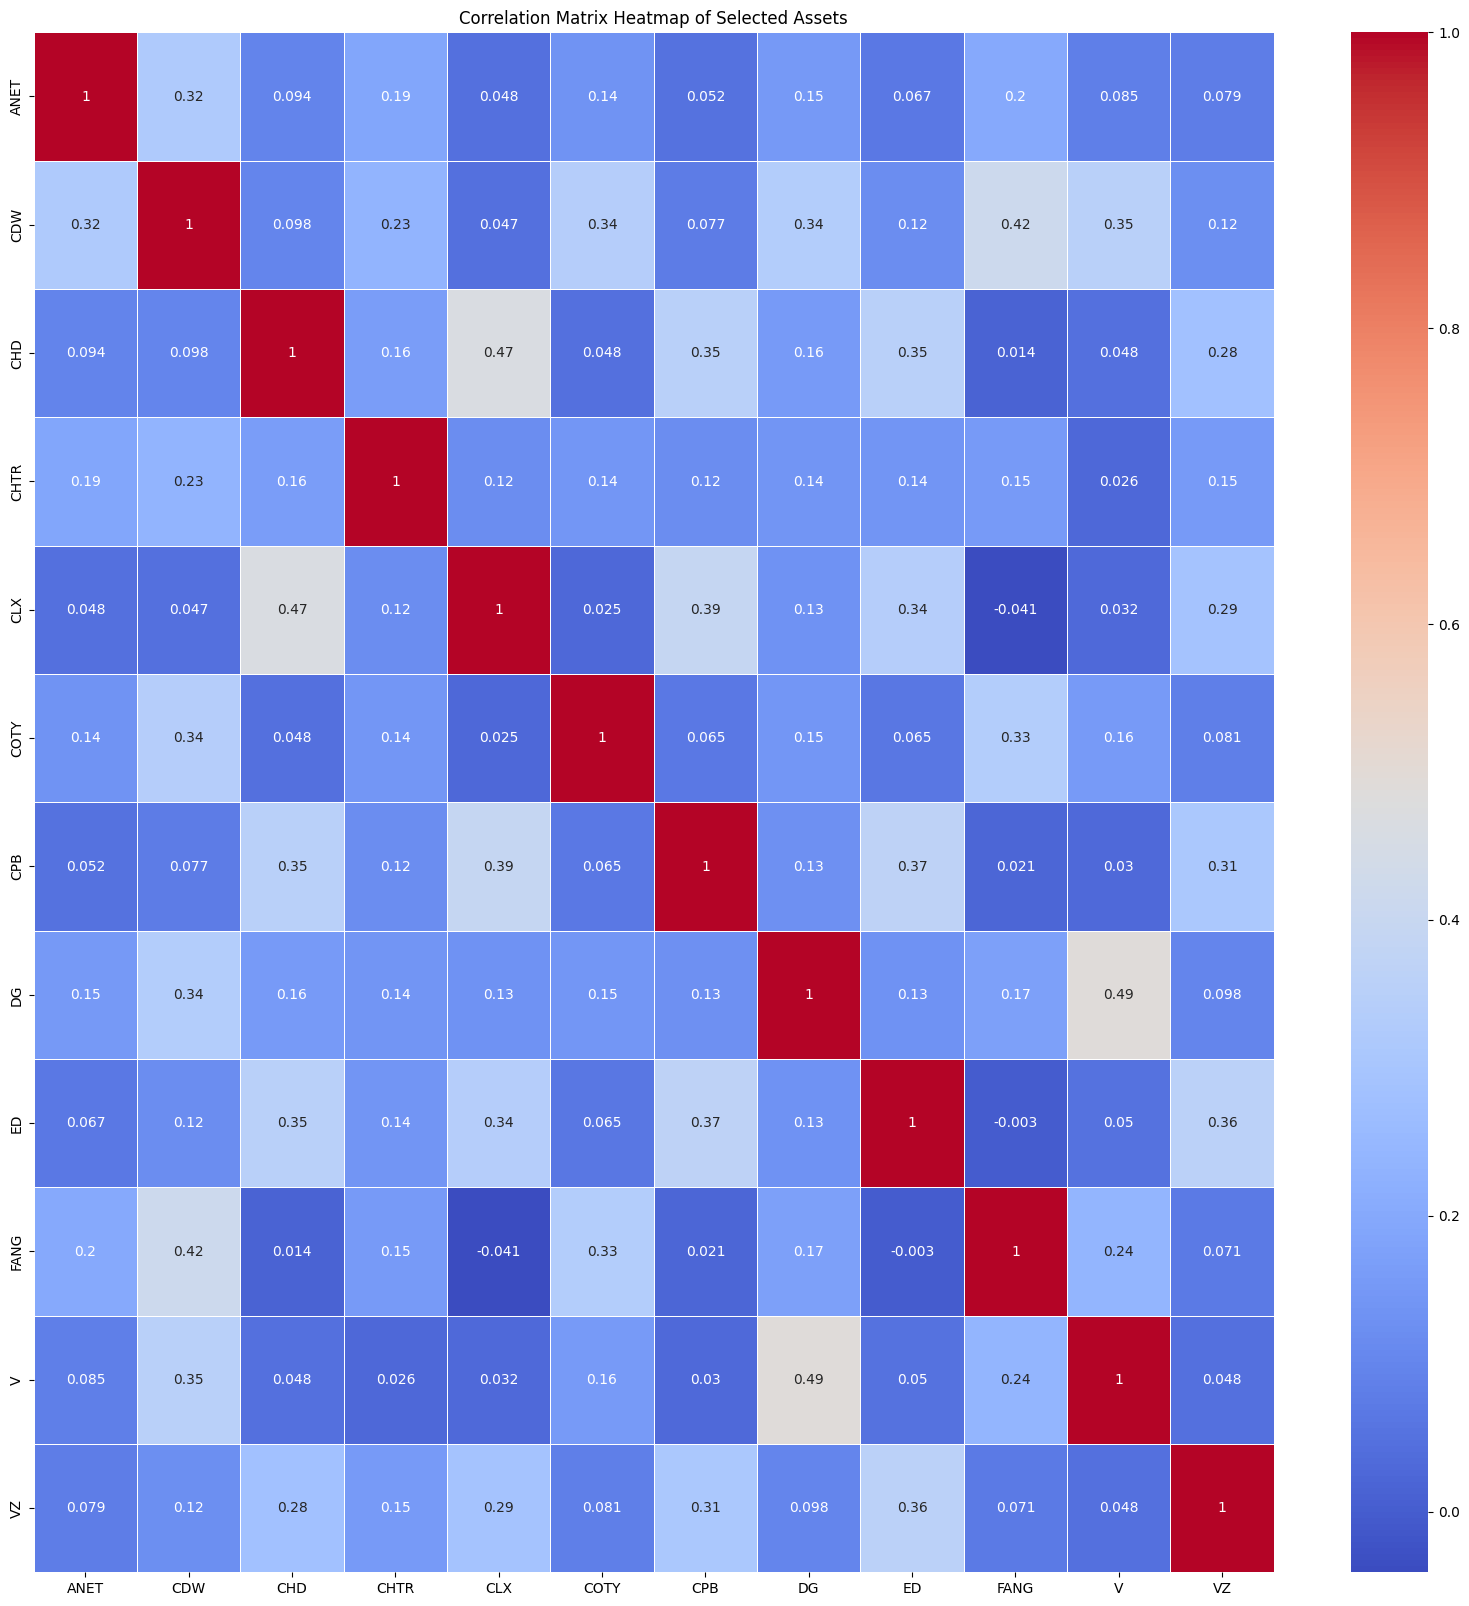

In [191]:
# Filter columns in df where the corresponding weight in w_min is greater than 0
filtered_df = df[filtered_names]

# Compute the correlation matrix
corr_matrix = filtered_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap of Selected Assets')
plt.show()


Now let us create a dataframe of results

In [192]:
#Get the values
returns = ret(r, w_allocation) * 100
risk = portfolio_volatility(w_allocation)*100

# Append the values to the DataFrame
new_row = pd.DataFrame({'return': [returns], 'risk': [risk]})

#Save the dataframe
new_row.to_excel("Vanilla_Results.xlsx",index=False)

Testing the model

In [193]:
# Calculate expected returns for each asset
expected_returns_test = np.mean(test,axis=0)*252

# Calculate the variance-covariance matrix
cov_matrix_test = test.cov()


#Converting the expected returns to a numpy array
expected_returns_test = expected_returns_test.values

In [194]:
#Actual Return
Actual_Return = sum(x * y for x, y in zip(expected_returns_test, w_allocation))
print(Actual_Return)

0.03454904477260848


In [195]:
#Actual Risk
Actual_Risk = np.sqrt(np.dot(np.dot(w_allocation.T, cov_matrix_test), w_allocation))*np.sqrt(252)
print(Actual_Risk)

0.191597482450442
